# Training a Vanilla Classifier with the MNIST dataset

In this notebook, I will be training both a CNN and an MLP to classify the MNIST problem. The main objective of both implementations is to study how to implement LRP algorithms for further understanding within our laboratory. 

This notebook was developed by Cesar Augusto Sanchez-Villalobos. @cesarasa in TTU and @CesarAugusto14 in GitHub. 

In [1]:
# Python libraries:
import os
import time

# Third-party libraries:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Specific classes and functions:
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import datasets, transforms

# Check the available devices (mps is to train on multiple GPUs, or in M1 Macs)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(device)

cuda


## Loading the data:

The MNIST dataset (images of size 28x28) is available in the `torchvision` library. We can:
- load the dataset using the `torchvision.datasets.MNIST` class.
- normalize the images and convert them to tensors. 
- use the `torch.utils.data.DataLoader` class to create batches of data.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), # normalize and convert ... is this the most robust method? What if we didn't know that the dataset was idx3-ubyte?
])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
def one_hot_encode(labels, num_classes):
    return torch.eye(num_classes)[labels]
# One hot encode the labels
# train_data.targets = one_hot_encode(train_data.targets, 10)
# test_data.targets = one_hot_encode(test_data.targets, 10)


# Split train into train and validation
train_data, val_data = random_split(train_data, [50000, 10000])

# Convert the labels into a one-hot encoded


# Data Loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)      # It is good practice to shuffle the training data as it helps the model to generalize better
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## MLP Model Construction and Training:

As can be seen in the autoencoder notebook, we can train a model by defining the forward pass in the `forward` method, and then create a training loop sequence or function to train the `torch.nn.Module` object. However, another way is to define further methods to train the model. In this notebook, I will be defining a `fit` and a `predict` method, to train the model and to predict the output of the model, respectively. 

As an initial approach, I will be using a simple MLP model with variable Hidden Layers and Units per layer. The model will be trained using the MNIST dataset. 

The `MLP` class is shown in the following cell:

In [5]:
class MLP(nn.Module):
    """
    The following class defines a tunable MLP model. It will have: 
    
    n_layers : number of hidden layers in the network.
    n_units  : number of units in each hidden layer.
    n_inputs : number of input features.
    n_outputs: number of output features.
    """
    
    def __init__(self, n_layers : int,
                       n_units  : int,
                       n_inputs : int,
                       n_outputs: int):
        super(MLP, self).__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        # Initialize the list of layers
        self.layers = nn.ModuleList()
        
        assert n_layers > 0, "Number of hidden layers must be greater than 0."
        
        # Add the first hidden layer
        self.layers.append(nn.Linear(n_inputs, n_units))
        
        # Add the remaining hidden layers
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(n_units, n_units))
            
        # Add the output layer
        self.layers.append(nn.Linear(n_units, n_outputs))
        
    def forward(self, x):
        """
        Forward pass of the network.
        """
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        return self.layers[-1](x)
    
    def summary(self):
        """
        Print the summary of the network.
        """
        print(summary(self, (1, self.n_inputs)))
        
    def fit(self, train_loader : torch.utils.data.DataLoader,
            val_loader   : torch.utils.data.DataLoader,
            n_epochs     : int,
            lr           : float,
            criterion    : torch.nn.modules.loss,
            device       : torch.device):
        """
        Fit the model to the data.
        """
        # Send the model to the device
        self.to(device)
        
        # Initialize the optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        # Initialize the history dictionary
        history = {'train_loss': [], 'val_loss': []}
        
        # Train the model
        for epoch in range(n_epochs):
            train_loss = 0.0
            val_loss = 0.0
            
            # Train the model
            self.train()
            for x, y in train_loader:
                x, y = x.to(device), one_hot_encode(y, 10).to(device)
                optimizer.zero_grad()
                y_hat = self(x.view(x.size(0), -1))
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            history['train_loss'].append(train_loss / len(train_loader))
            
            # Validate the model
            self.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_hat = self(x.view(x.size(0), -1))
                    loss = criterion(y_hat, y)
                    val_loss += loss.item()
                history['val_loss'].append(val_loss / len(val_loader))
                
            # Print the progress
            print(f'Epoch {epoch + 1}/{n_epochs} | Train Loss: {history["train_loss"][-1]:.5f} | Val Loss: {history["val_loss"][-1]:.5f}')
            if epoch+1 == n_epochs:
                print('Finished Training')
                print('Final Train Loss: ', train_loss/len(train_loader))
        return history
        
    def predict(self, test_loader : torch.utils.data.DataLoader,
                device : torch.device):
        """
        Predict the labels of the test data.
        """
        self.eval()
        predictions = []
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                y_hat = self(x.view(x.size(0), -1))
                predictions.extend(y_hat.argmax(dim=1).cpu().numpy())
        return predictions
        
model = MLP(n_layers=1, n_units=5, n_inputs=28*28, n_outputs=10).to(device)

# Print the model summary
model.summary()

# Define the hyperparameters
n_epochs = 10
lr = 1e-3
criterion = nn.CrossEntropyLoss()

# Fit the model
history = model.fit(train_loader, val_loader, n_epochs, lr, criterion, device)


Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 5]                3,925
|    └─Linear: 2-2                       [-1, 1, 10]               60
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 5]                3,925
|    └─Linear: 2-2                       [-1, 1, 10]               60
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
Epoch 

As can be seen, we are getting a the `fit` and `predict` methods are working properly for the MLP model. Thus, we can always call it and train any MLP model with constant number of hidden units per layer, and variable number of layers. We then trained one instance of the MLP class with 1 hidden layer and 5 hidden units, and get a loss of 0.35913 in the train set, and 0.37736 in the validation set. We can see the loss plot in the following cell.

### Loss Plot of the MLP model:

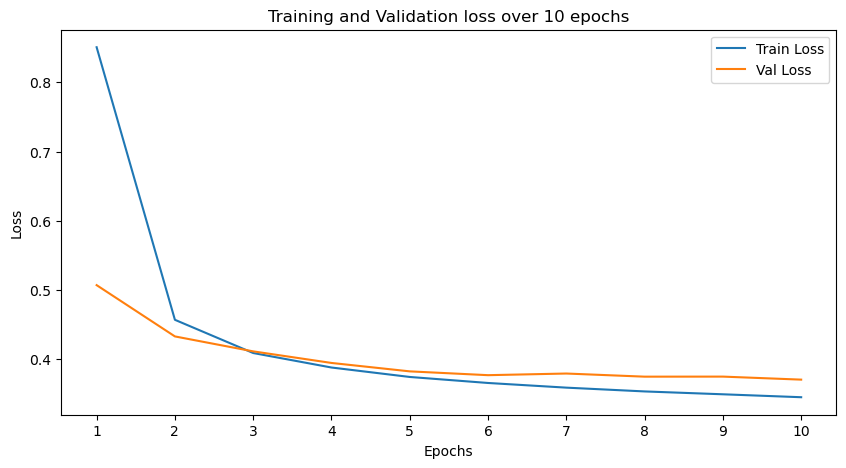

In [6]:
# Plot 
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11, 1), history['train_loss'], label='Train Loss')
plt.plot(np.arange(1, 11, 1), history['val_loss']  , label='Val Loss')
# The xticks go from 1 to 10
plt.xticks(np.arange(1, 11, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss over 10 epochs')
plt.show()

### Predictions made by the MLP model:

The predictions made by the MLP model are shown in the following cell. We are only seeing one mistake, which is the 9th image in the test set. The model predicted a 6, but the label is 5. To be completely fair with the model, it seems that the image is slightly hard to understand, maybe the handwritting is not clear enough. However, we do not know how many times the model was wrong, so we need to compute the number of mistakes made. 

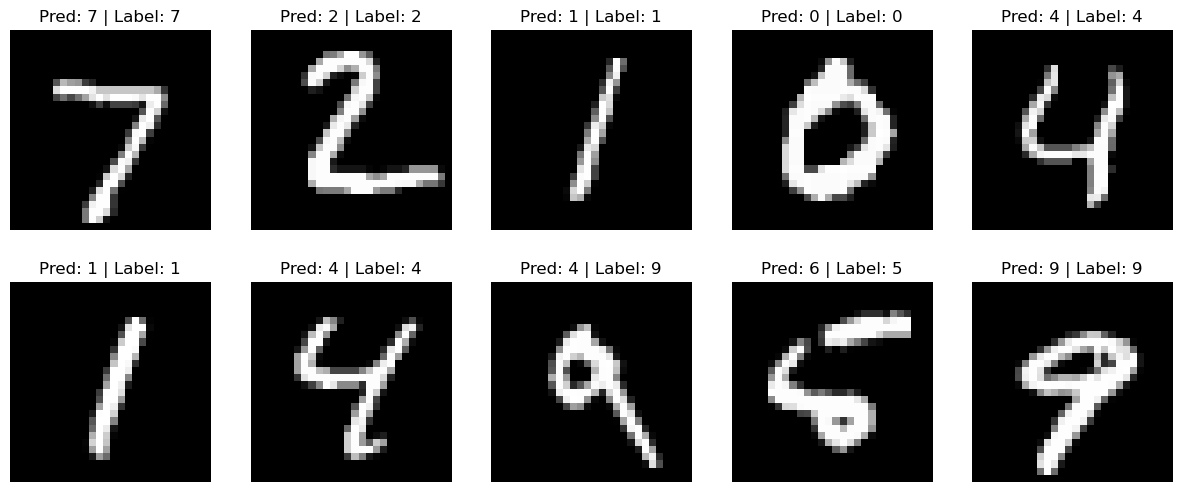

In [7]:
# Infer on the test data
predictions = model.predict(test_loader, device)
# Show the first 10 predictions with their corresponding images and labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
labels = test_data.targets[:10].numpy()
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(test_data.data[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[i]} | Label: {labels[i]}')
plt.show()

# Print the first 10 labels
# print(test_data.targets[:10].numpy())

### Assessing the performance of the MLP model:

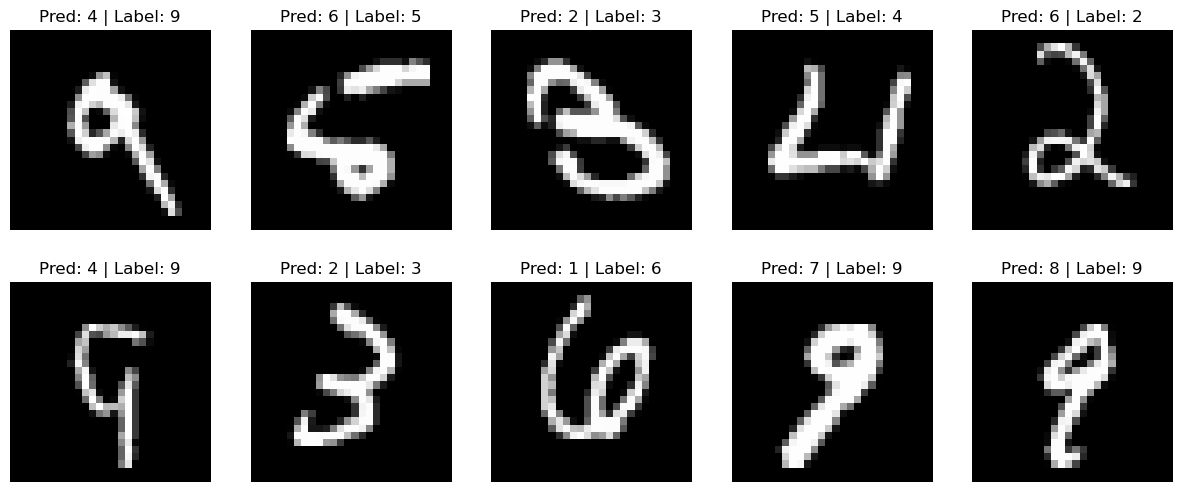

Number of misclassified images: 1014
Accuracy: 0.90


In [8]:
# Find the Images that were misclassified
misclassified = []
for i in range(len(predictions)):
    if predictions[i] != test_data.targets[i]:
        misclassified.append(i)
        
# Show the first 10 misclassified images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(test_data.data[misclassified[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[misclassified[i]]} | Label: {test_data.targets[misclassified[i]]}')
    
plt.show()

# Print the number of misclassified images
print(f'Number of misclassified images: {len(misclassified)}')

# Compute the Accuracy:
accuracy = 1 - len(misclassified) / len(predictions)
print(f'Accuracy: {accuracy:.2f}')

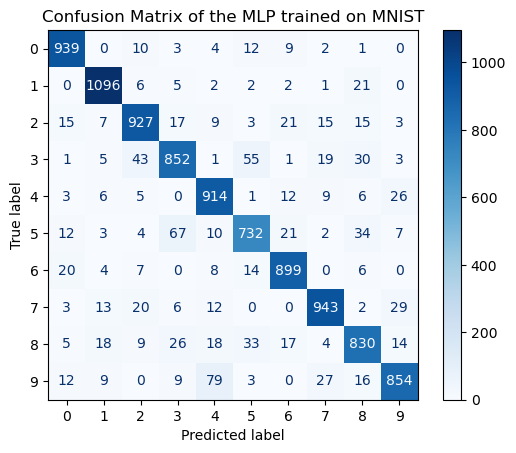

In [10]:
# Confussion Matrix:
cm = confusion_matrix(test_data.targets, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of the MLP trained on MNIST')
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/confusion_simple_MLP_MNIST.png')
plt.show()

# Save model:
if not os.path.exists('models'):
    os.makedirs('models')
    
torch.save(model, 'models/simple_MLP_MNIST.pth')

As can be seen, the MLP model has an accuracy of 0.89 in the test set. This can be easily improved by adding more hidden units and hidden layers. However, our current interest is not exactly to improve the accuracy of the model, so we will keep this model for the next LRP implementation. 

In the confusion matrix, we can also see that most of the errors are coming from trying to predict 5 (getting a lot of 3s), and 4 or 9 (getting a lot of misclassifications between them).

As a reminder, we used 1 hidden layer with 5 hidden units, and trained the model for 10 epochs with a learning rate of 0.001. 

## CNN Model Construction and Training:

We will implement the CNN model following the same structure as the MLP model. We can try initially to implement LeNet-5, which we know is a good model for the MNIST dataset. We will then train the model using the MNIST dataset.

In [8]:
# Now I will build a CNN model:

class LeNet5(nn.Module):
    """
    The following class defines the LeNet5 architecture.
    
    - The batch size will be N. 
    - The number of input channels will be 1.
    - The height and width will be 28 and 28, respectively.
    
    Thus, the input tensor will have the shape (N, 1, 28, 28).
    
    I will then need: 
    
    - A convolutional layer with 6 feature maps, each with a kernel size of 5x5, and 2 padding.
    Output shape: (N, 6, 28, 28)
    
    - A max pooling layer with a kernel size of 2x2.
    Output shape: (N, 6, 14, 14)
    
    - A convolutional layer with 16 feature maps, each with a kernel size of 5x5, and 2 padding.
    Output shape: (N, 16, 14, 14)
    - A max pooling layer with a kernel size of 2x2.
    Output shape: (N, 16, 7, 7)
    - Then We flatten:
    Output shape: (N, 16*7*7)
    - A fully connected layer with 120 units. 
    Output shape: (N, 120)
    - A fully connected layer with 84 units.
    Output shape: (N, 84)
    - A fully connected layer with 10 units.
    
    The output of the NN then will be a tensor of shape (N, 10).
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(16*7*7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = torch.sigmoid(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return self.fc3(x)
    
    def summary(self):
        print(summary(self, (1, 28, 28)))
        
    def fit(self, train_loader : torch.utils.data.DataLoader,
            val_loader   : torch.utils.data.DataLoader,
            n_epochs     : int,
            lr           : float,
            criterion    : torch.nn.modules.loss,
            device       : torch.device):
        self.to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(n_epochs):
            train_loss = 0.0
            val_loss = 0.0
            self.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = self(x)
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            history['train_loss'].append(train_loss / len(train_loader))
            self.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    y_hat = self(x)
                    loss = criterion(y_hat, y)
                    val_loss += loss.item()
                history['val_loss'].append(val_loss / len(val_loader))
            print(f'Epoch {epoch + 1}/{n_epochs} | Train Loss: {history["train_loss"][-1]:.5f} | Val Loss: {history["val_loss"][-1]:.5f}')
            if epoch+1 == n_epochs:
                print('Finished Training')
                print('Final Train Loss: ', train_loss/len(train_loader))
        return history
    
    def predict(self, test_loader : torch.utils.data.DataLoader,
                device : torch.device):
        self.eval()
        predictions = []
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                y_hat = self(x)
                predictions.extend(y_hat.argmax(dim=1).cpu().numpy())
        return predictions

    
# Check if the model is working:
model = LeNet5().to(device)
model.summary()

# Define the hyperparameters
n_epochs = 10
lr = 1e-3
criterion = nn.CrossEntropyLoss()

# Fit the model
history = model.fit(train_loader, val_loader, n_epochs, lr, criterion, device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 14, 14]           2,416
            Linear-3                  [-1, 120]          94,200
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 107,786
Trainable params: 107,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.41
Estimated Total Size (MB): 0.48
----------------------------------------------------------------
None
Epoch 1/10 | Train Loss: 1.03865 | Val Loss: 0.29370
Epoch 2/10 | Train Loss: 0.20675 | Val Loss: 0.16508
Epoch 3/10 | Train Loss: 0.12401 | Val Loss: 0.10624
Epoch 4/10 | Train Loss: 0.09122 | Val Loss: 0.09414
Epoch 5/10 | Trai

### Loss Plot of the CNN model:

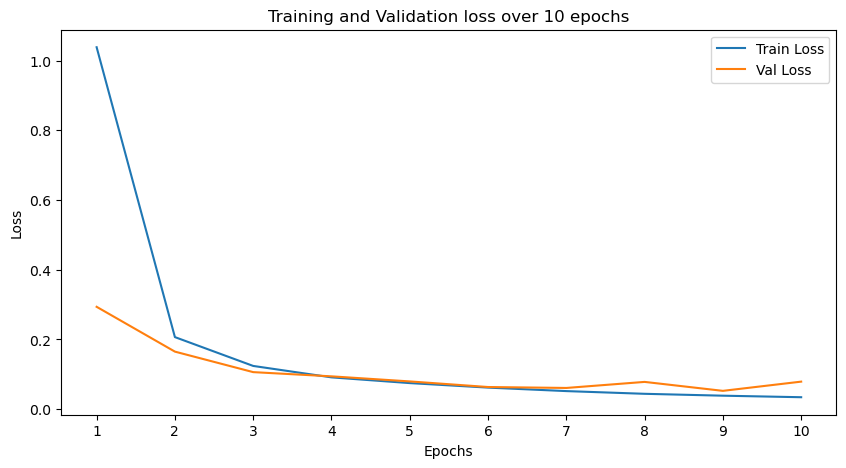

In [14]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 11, 1), history['train_loss'], label='Train Loss')
plt.plot(np.arange(1, 11, 1), history['val_loss']  , label='Val Loss')
plt.xticks(np.arange(1, 11, 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss over 10 epochs')
plt.show()

# Save Model:
torch.save(model, 'models/LeNet5_MNIST.pth')

### Predictions made by the CNN model:

As can be seen in the below image, now the model is able to predict the 9th image in the test set correctly. This is a good sign, however, we need to compute the number of mistakes made by the model.

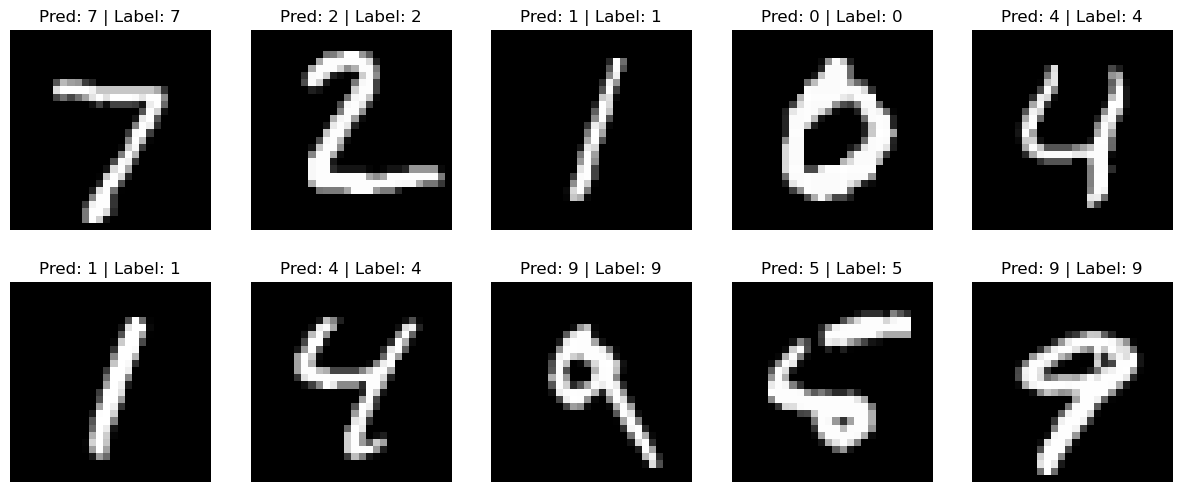

In [15]:
predictions = model.predict(test_loader, device)
# Show the first 10 predictions with their corresponding images and labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
labels = test_data.targets[:10].numpy()
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(test_data.data[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[i]} | Label: {labels[i]}')
plt.show()

# Print the first 10 labels
# print(test_data.targets[:10].numpy())

### Assessing the performance of the CNN model:

Number of misclassified images: 192
Accuracy: 98.08%


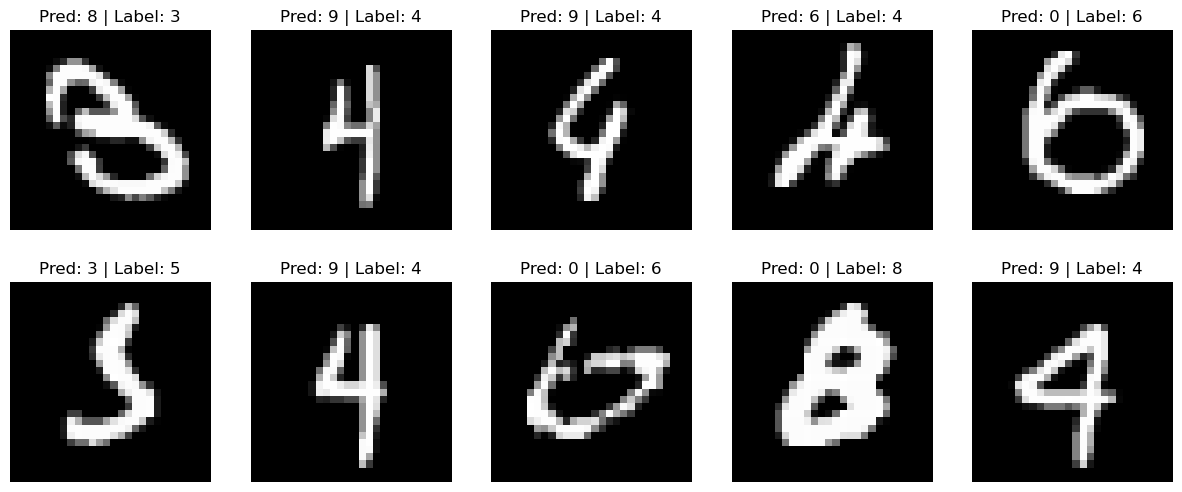

In [16]:
misclassified = []
for i in range(len(predictions)):
    if predictions[i] != test_data.targets[i]:
        misclassified.append(i)
        
# Print number of misclassified images
print(f'Number of misclassified images: {len(misclassified)}')

# Print the accuracy
accuracy = 1 - len(misclassified) / len(predictions)
print(f'Accuracy: {accuracy *100:.2f}%')

# Show the first 10 misclassified images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(test_data.data[misclassified[i]], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pred: {predictions[misclassified[i]]} | Label: {test_data.targets[misclassified[i]]}')

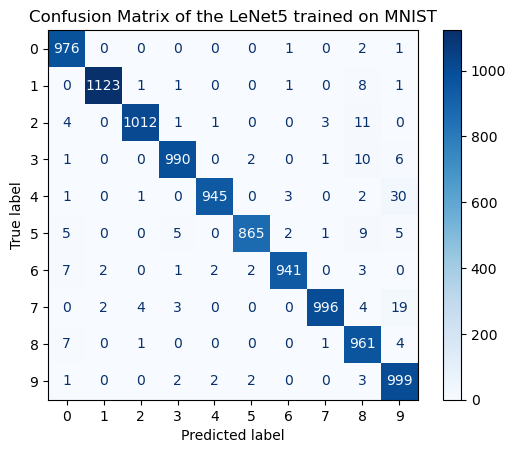

In [12]:
# Confussion Matrix:
cm = confusion_matrix(test_data.targets, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix of the LeNet5 trained on MNIST')
plt.savefig('figures/confusion_LeNet5_MNIST.png')
plt.show()


Now we can see that with a very simple CNN (with two convolutional layers and two fully connected layers), we are able to achieve an accuracy of 0.98 in the test set.

Also, we can see that the misclassified images are very hard to identify also by humans, which makes the model to have an almost human performance. 

# Implementation of Interpretability Algorithms:

As it is interest of several members from Dr. Ranadip Pal laboratory, we need to start implementing interpretability algorithms. As an initial approach, we will be studying the Layer-wise Relevance Propagation (LRP) algorithm.

## Layer-wise Relevance Propagation (LRP) Algorithm, for the MLP model:

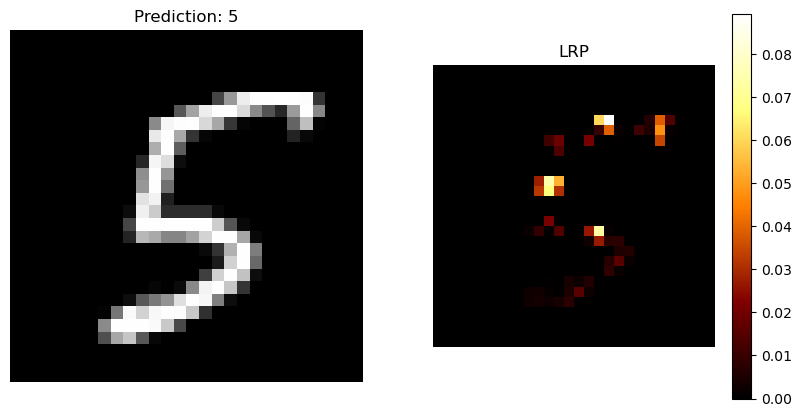

In [74]:
from captum.attr import LRP

# Use the LRP algorithm
lrp = LRP(model)

# Get the first image
x, y = test_data[23]
x = x.to(device)

# Get the prediction
y_hat = model(x.unsqueeze(0))
prediction = y_hat.argmax().item()

# Compute the LRP
attribution = lrp.attribute(x.unsqueeze(0), target=prediction)

# Plot the image and the attribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x.cpu().numpy().squeeze(), cmap='gray')
axs[0].axis('off')
axs[0].set_title(f'Prediction: {prediction}')
axs[1].imshow(attribution.squeeze().cpu().detach().numpy(), vmin=0)
axs[1].axis('off')
axs[1].set_title('LRP')
# Colormap
plt.colorbar(axs[1].imshow(attribution.squeeze().cpu().detach().numpy(), vmin=0, cmap='afmhot'))
plt.show()

## LIME

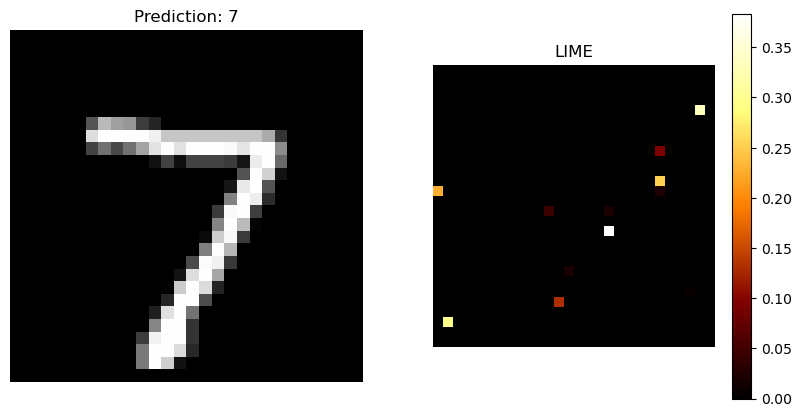

In [77]:
# Applying LIME to the LeNet5 model
from captum.attr import Lime

# Use the Lime algorithm
lime = Lime(model)

# Get the first image
x, y = test_data[0]
x = x.to(device)

# Get the prediction
y_hat = model(x.unsqueeze(0))
prediction = y_hat.argmax().item()

# Compute the Lime
attribution = lime.attribute(x.unsqueeze(0), target=prediction)

# Plot the image and the attribution
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x.cpu().numpy().squeeze(), cmap='gray')
axs[0].axis('off')
axs[0].set_title(f'Prediction: {prediction}')
axs[1].imshow(attribution.squeeze().cpu().detach().numpy(), vmin=0)
axs[1].axis('off')
axs[1].set_title('LIME')
# Colormap
plt.colorbar(axs[1].imshow(attribution.squeeze().cpu().detach().numpy(), vmin=0, cmap='afmhot'))
plt.show()
